In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Wed Oct 29 14:29:19 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Show versions of Vivarium libraries

In [3]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [4]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@fc5ccf522118f76d1032f9ecf80b90ed4bef40c2#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@f9190d90327e2ef8c907cd8edf7bd0648d44d214#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V list

# Find data

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.6/united_states_of_america/2025_10_29_10_59_31/

In [6]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [7]:
# Results directory containing model 7.6 results for all locations
model_run_subdir = 'results/model7.6/united_states_of_america/2025_10_29_10_59_31/'
!ls -halt $model_run_subdir/results

total 35M
drwxrwsr-x 5 albrja IHME-Simulationscience 4.5K Oct 29 13:48 ..
drwxrwsr-x 2 albrja IHME-Simulationscience 6.5K Oct 29 13:48 .
-rw-rw-r-- 1 albrja IHME-Simulationscience 2.0M Oct 29 13:48 person_time_ever_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 1.3M Oct 29 13:48 counts_baseline_tests_among_eligible.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 288K Oct 29 13:47 counts_newly_eligible_for_bbbm_testing.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 531K Oct 29 13:47 transition_count_treatment.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 213K Oct 29 13:47 counts_bbbm_tests.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 747K Oct 29 13:47 deaths.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 3.2M Oct 29 13:47 person_time_treatment.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience 454K Oct 29 13:47 counts_new_simulants.parquet
-rw-rw-r-- 1 albrja IHME-Simulationscience  11M Oct 29 13:47 ylds.parquet
-rw-rw-r-- 1 albrja IHM

In [8]:
!ls $model_run_subdir

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [9]:
!ls artifacts/model7.0

 brazil.hdf    japan.hdf   'taiwan_(province_of_china).hdf'
 china.hdf     logs	    united_kingdom.hdf
 germany.hdf   spain.hdf    united_states_of_america.hdf
 israel.hdf    sweden.hdf


In [10]:
locations = [
    'United States of America',
    # 'Brazil',
    # 'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '7.0' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# Option 1: One results directory per location
location_to_results_dir = {
    loc: path for loc, path in zip(locations, results_dirs)}

# # Option 2: All locations in one results directory
# location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf': 'United States of America'}

In [11]:
results_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model7.6/united_states_of_america/2025_10_29_10_59_31/results/']

In [12]:
d = results_dirs[0]
!ls $d

counts_baseline_tests_among_eligible.parquet
counts_bbbm_tests.parquet
counts_new_simulants.parquet
counts_newly_eligible_for_bbbm_testing.parquet
deaths.parquet
person_time_alzheimers_disease_and_other_dementias.parquet
person_time_eligible_for_bbbm_testing.parquet
person_time_ever_eligible_for_bbbm_testing.parquet
person_time_treatment.parquet
transition_count_alzheimers_disease_and_other_dementias.parquet
transition_count_treatment.parquet
ylds.parquet
ylls.parquet


# Get list of draws and draw columns from `keyspace.yaml`, and reduce to a subset of draws to save memory and time

In [13]:
with open(run_dirs[0] + 'keyspace.yaml', 'r') as keyspace_file:
    keyspace = yaml.safe_load(keyspace_file)
draws = keyspace['input_draw']
print(draws)

[457, 169, 323, 392, 346, 480, 258, 446, 356, 273, 158, 24, 265, 317, 177, 199, 2, 13, 46, 89, 41, 113, 262, 460, 499]


In [14]:
# I ended up never actually using this -- I just used all the draws
draws = sorted(draws[:10]) # reduce to a subset of draws to save memory, and sort
draw_cols = [f'draw_{i}' for i in draws]
print(draw_cols)

['draw_169', 'draw_258', 'draw_273', 'draw_323', 'draw_346', 'draw_356', 'draw_392', 'draw_446', 'draw_457', 'draw_480']


# Define some ordered Categorical dtypes, and convert years to ints

In [15]:
# Order locations lexicographically
all_locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]
location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [16]:
usa_artifact_path = location_to_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [17]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


In [18]:
age_bins.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19 entries, (6, '5 to 9', 5.0, 10.0) to (235, '95 plus', 95.0, 125.0)
Empty DataFrame


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [19]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Load CSF and PET testing rates

In [20]:
# NOTE: Dropping level 1 of index because it is meaningless, containing
# all 0s: 
# https://github.com/ihmeuw/vivarium_csu_alzheimers/blob/7674a25da52e8b9ee23c0184a2e65c6f53aac335/src/vivarium_csu_alzheimers/data/loader.py#L487-L489
csf_rates = load_artifact_data('testing_rates.csf').droplevel(1)
pet_rates = load_artifact_data('testing_rates.pet').droplevel(1)
existing_test_rates = (
    pd.concat(
        {'csf': csf_rates, 'pet': pet_rates}, names=['test_type', 'location'])
    .rename_axis(columns='input_draw')
)
existing_test_rates

,input_draw,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_490,draw_491,draw_492,draw_493,draw_494,draw_495,draw_496,draw_497,draw_498,draw_499
test_type,location,,,,,,,,,,,,,,,,,,,,,
csf,United States of America,0.086170,0.140511,0.102449,0.092320,0.126445,0.062653,0.118921,0.087192,0.096971,0.095522,...,0.131668,0.137619,0.117952,0.089317,0.107378,0.123519,0.079365,0.137440,0.123465,0.089654
pet,United States of America,0.172089,0.196148,0.165458,0.088834,0.164784,0.180419,0.178008,0.223862,0.120794,0.154591,...,0.160961,0.236646,0.166553,0.113526,0.101062,0.201854,0.180972,0.164552,0.150534,0.096107


In [21]:
existing_test_rates.stack().rename('value').to_frame()

value
test_type location                 input_draw          
csf       United States of America draw_0      0.086170
                                   draw_1      0.140511
                                   draw_2      0.102449
                                   draw_3      0.092320
                                   draw_4      0.126445
...                                                 ...
pet       United States of America draw_495    0.201854
                                   draw_496    0.180972
                                   draw_497    0.164552
                                   draw_498    0.150534
                                   draw_499    0.096107

[1000 rows x 1 columns]

# Define functions to load simulation output and summarize it for plotting

In [22]:
# Create an operator object
ops = VPHOperator()
ops.index_cols.append('location')

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are in a single" \
            " results directory"
        )

    dfs = []
    for location, directory in results_dict.items():

        parquet_file_path = Path(directory) / f'{measure}.parquet'
        # Read the Parquet file's schema to get column names and data types
        parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Change this to logging instead of printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # Invert the dictionary so we can map artifact paths to
                # locations
                # NOTE: Guaranteed not to be None because
                # assign_location is True
                artifact_path_to_location = {
                    path: loc for loc, path in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Load baseline test counts

In [23]:
# On the first attempt, this resulted in an empty DataFrame. Using
# raw=True, I determined that the .groupby was failing because of NaNs
# in the sub_entity column, since dropna=True by default.
existing_tests = load_sim_output(
    'counts_baseline_tests_among_eligible',
    # location_to_artifact_path=None,
    # raw=True,
)
# Memory usage is almost 3 GB when loading without Categoricals
print_memory_usage(existing_tests)
existing_tests

7.015923 MB


,age_group,entity,entity_type,event_year,input_draw,measure,scenario,sex,testing_state,value,location
0,25_to_29,baseline_testing,testing,2025,113,counts_baseline_tests_among_eligible,baseline,Female,not_tested,0.0,United States of America
1,25_to_29,baseline_testing,testing,2025,113,counts_baseline_tests_among_eligible,baseline,Female,csf,0.0,United States of America
2,25_to_29,baseline_testing,testing,2025,113,counts_baseline_tests_among_eligible,baseline,Female,pet,0.0,United States of America
3,25_to_29,baseline_testing,testing,2025,113,counts_baseline_tests_among_eligible,baseline,Female,bbbm,0.0,United States of America
4,25_to_29,baseline_testing,testing,2025,113,counts_baseline_tests_among_eligible,baseline,Male,not_tested,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...
368995,95_plus,baseline_testing,testing,2065,392,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Female,bbbm,0.0,United States of America
368996,95_plus,baseline_testing,testing,2065,392,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Male,not_tested,18.0,United States of America
368997,95_plus,baseline_testing,testing,2065,392,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Male,csf,2.0,United States of America
368998,95_plus,baseline_testing,testing,2065,392,counts_baseline_tests_among_eligible,bbbm_testing_and_treatment,Male,pet,5.0,United States of America


In [24]:
# # Column doesn't exist when using simulate for one location instead of
# # psimulate for multpile locations
# existing_tests.artifact_path.unique()

In [25]:
existing_tests.location.unique()

['United States of America']
Categories (10, object): ['Brazil' < 'China' < 'Germany' < 'Israel' ... 'Sweden' < 'Taiwan (Province of China)' < 'United Kingdom' < 'United States of America']

In [26]:
# Check memory usage -- loading it raw, it took up 2.1 GB
existing_tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369000 entries, 0 to 368999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      369000 non-null  category
 1   entity         369000 non-null  category
 2   entity_type    369000 non-null  category
 3   event_year     369000 non-null  int16   
 4   input_draw     369000 non-null  category
 5   measure        369000 non-null  category
 6   scenario       369000 non-null  category
 7   sex            369000 non-null  category
 8   testing_state  369000 non-null  category
 9   value          369000 non-null  float64 
 10  location       369000 non-null  category
dtypes: category(9), float64(1), int16(1)
memory usage: 6.7 MB


In [27]:
# See if there is only one measure, or more
existing_tests.measure.unique()

['counts_baseline_tests_among_eligible']
Categories (1, object): ['counts_baseline_tests_among_eligible']

In [28]:
# Check whether all values are integers -- yes
(existing_tests.value % 1).unique()

array([0.])

# Divide to calculate CSF/PET testing rates from sim

In [29]:
sim_test_rates = ops.ratio(
    existing_tests,
    existing_tests,
    strata = ['event_year'],
    numerator_broadcast='testing_state',
)
sim_test_rates

,event_year,input_draw,scenario,location,testing_state,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,United States of America,not_tested,0.738597,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
1,2025,2,baseline,United States of America,csf,0.105282,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
2,2025,2,baseline,United States of America,pet,0.156120,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
3,2025,2,baseline,United States of America,bbbm,0.000000,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
4,2025,2,bbbm_testing,United States of America,not_tested,0.738597,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
...,...,...,...,...,...,...,...,...,...
12295,2065,499,bbbm_testing,United States of America,bbbm,0.018403,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
12296,2065,499,bbbm_testing_and_treatment,United States of America,not_tested,0.849657,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
12297,2065,499,bbbm_testing_and_treatment,United States of America,csf,0.063007,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1
12298,2065,499,bbbm_testing_and_treatment,United States of America,pet,0.068933,counts_baseline_tests_among_eligible,counts_baseline_tests_among_eligible,1


# Plot test CSF/PET test rates

Let's make a grid of plots with one column for each scenario and one row
for each country. In each axes, plot testing rate over time, with one
line for each of the four testing states, and plot Artifact testing
rates in same color but different line style.

In [30]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

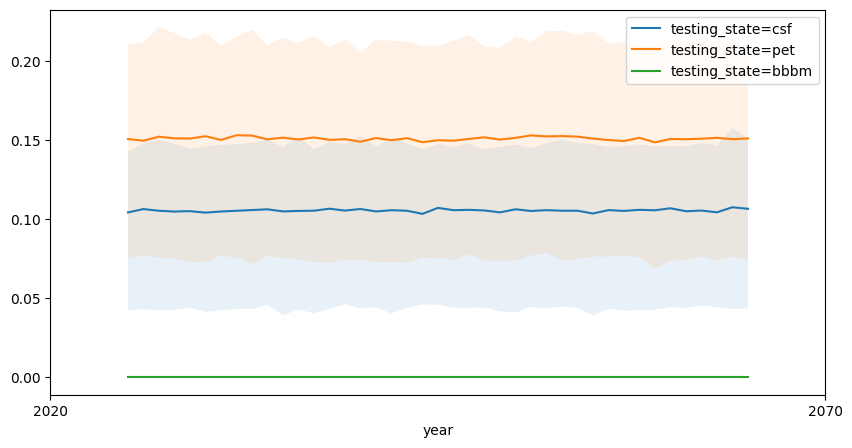

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
plot_over_time_by_column(
    sim_test_rates
    .query("location == 'United States of America' and scenario == 'baseline' and testing_state != 'not_tested'"),
    'testing_state')
ax.set_xticks(ax.get_xticks()[::10])
# ax.tick_params(rotation=90)
plt.show()

# Plot existing test rates in baseline for each country

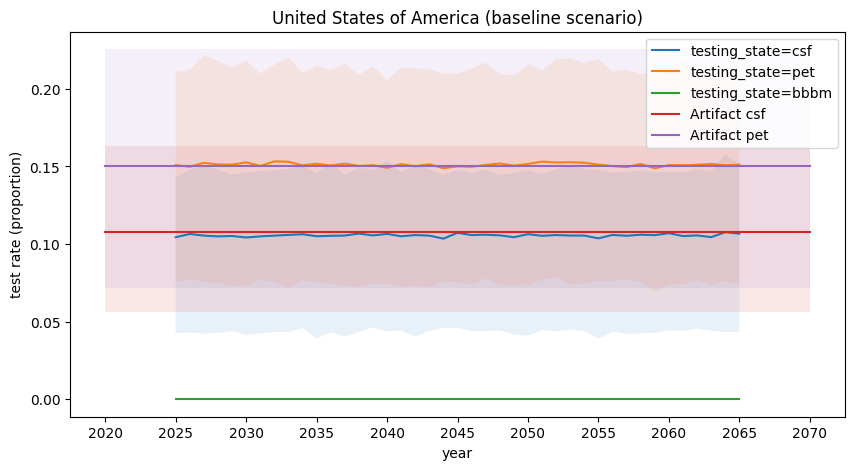

In [32]:
for location in locations:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_over_time_by_column(
        sim_test_rates
        .query("location == @location and scenario == 'baseline' and testing_state != 'not_tested'"),
        'testing_state',
        ylabel='test rate (proportion)',
        title=location + ' (baseline scenario)',
    )
    filtered_x_ticks = ax.get_xticks()#[::5]
    ax.set_xticks(filtered_x_ticks)

    artifact_testing_data = summarize_artifact_data(existing_test_rates).query("location==@location")
    for test_type in artifact_testing_data.index.unique('test_type'):
        ax.plot(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'mean'], (len(filtered_x_ticks),)),
            label=f'Artifact {test_type}'
        )
        ax.fill_between(
            filtered_x_ticks,
            np.broadcast_to(artifact_testing_data.loc[test_type, 'lower'], (len(filtered_x_ticks),)),
            np.broadcast_to(artifact_testing_data.loc[test_type, 'upper'], (len(filtered_x_ticks),)),
            alpha=.1,
        )
    # ax.tick_params(rotation=90)
    # ax.semilogy()
    # ax.set_ylim(0, 0.1)
    ax.legend()
    plt.show()

In [33]:
artifact_testing_data

,,mean,lower,upper
test_type,location,,,
csf,United States of America,0.108006,0.056326,0.163487
pet,United States of America,0.150082,0.071912,0.225537


# Plot existing tests in baseline and BBBM testing scenarios for one country

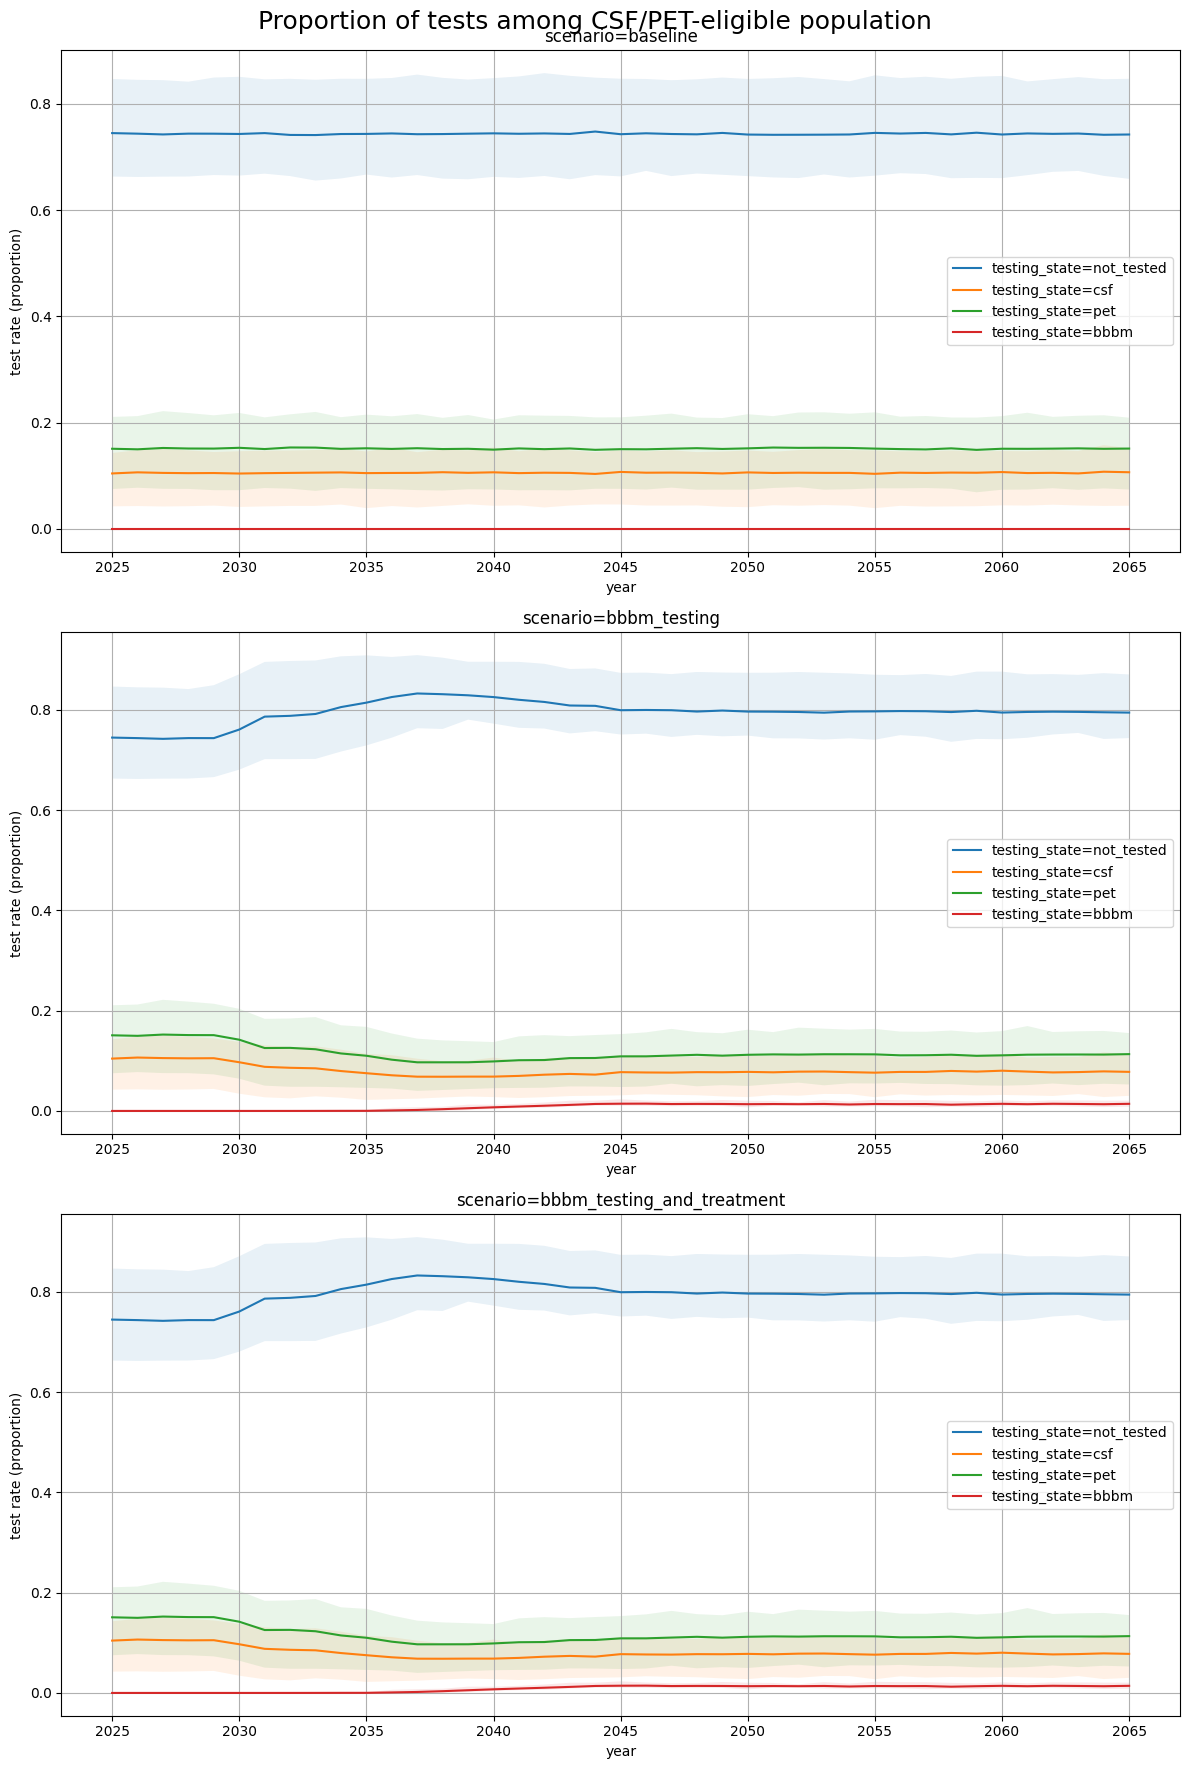

In [34]:
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("location == 'United States of America'"),
    'testing_state',
    'scenario',
    ylabel='test rate (proportion)',
    suptitle='Proportion of tests among CSF/PET-eligible population',
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in BBBM testing scenario for all countries

CSF now decreases at the same time as PET testing. Looks like the bugfix worked.

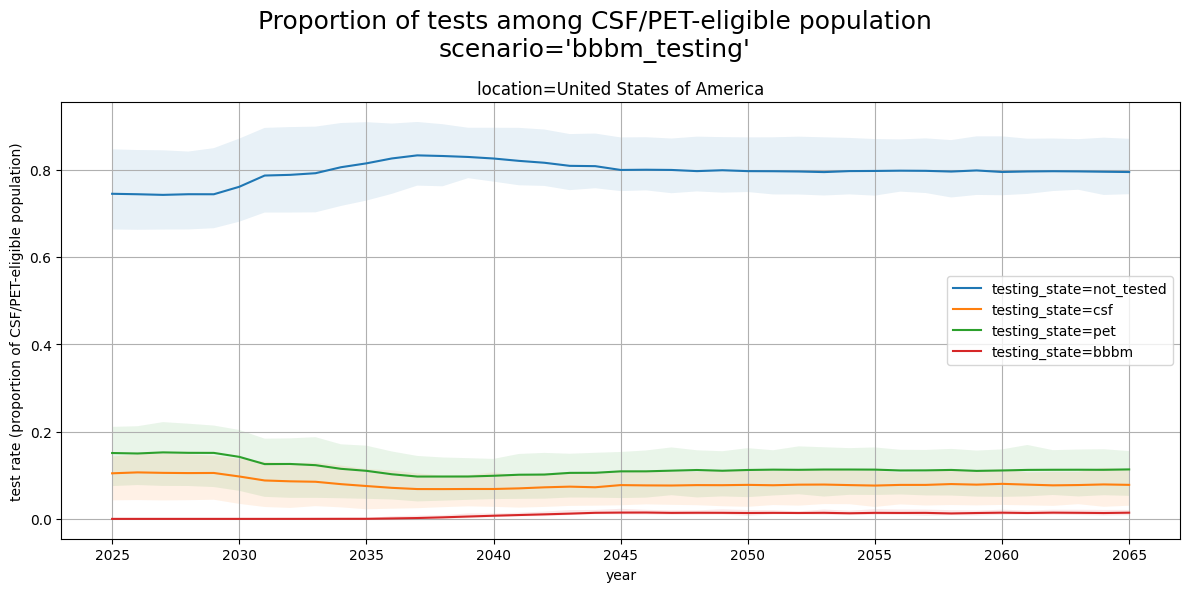

In [35]:
scenario='bbbm_testing'
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == @scenario"),
    'testing_state',
    'location',
    ylabel='test rate (proportion of CSF/PET-eligible population)',
    suptitle=(
        'Proportion of tests among CSF/PET-eligible population'
        f'\n{scenario=}'
    ),
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Plot existing test rates in treatment scenario for all countries

These graphs should look the same as the ones in the testing scenario.
And they do. Good.

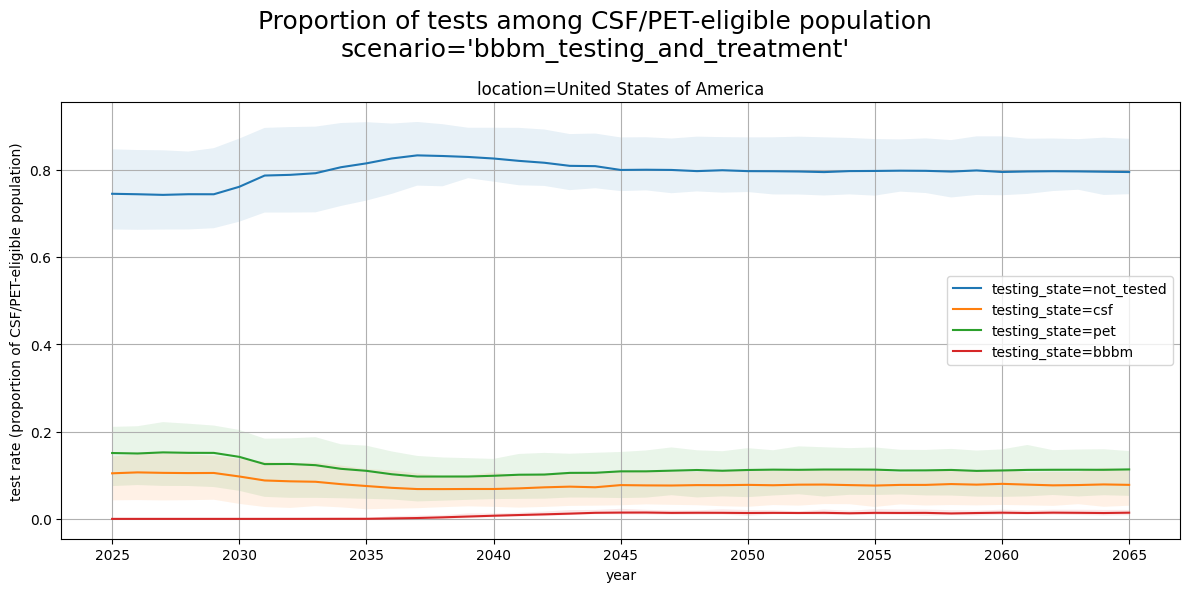

In [36]:
scenario='bbbm_testing_and_treatment'
fig = plot_over_time_by_column_for_row_x_1(
    sim_test_rates.query("scenario == @scenario"),
    'testing_state',
    'location',
    ylabel='test rate (proportion of CSF/PET-eligible population)',
    suptitle=(
        'Proportion of tests among CSF/PET-eligible population'
        f'\n{scenario=}'
    ),
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read BBBM testing data

In [37]:
bbbm_test_eligibility_counts = load_sim_output(
    'counts_newly_eligible_for_bbbm_testing',
)
print_memory_usage(bbbm_test_eligibility_counts)
bbbm_test_eligibility_counts

5.263056 MB


,age_group,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_newly_eligible_for_bbbm_testing,baseline,Female,0.0,United States of America
1,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_newly_eligible_for_bbbm_testing,baseline,Male,0.0,United States of America
2,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Female,0.0,United States of America
3,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Male,0.0,United States of America
4,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_newly_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...
276745,95_plus,negative,bbbm_testing,testing,2065,392,counts_newly_eligible_for_bbbm_testing,baseline,Male,0.0,United States of America
276746,95_plus,negative,bbbm_testing,testing,2065,392,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Female,0.0,United States of America
276747,95_plus,negative,bbbm_testing,testing,2065,392,counts_newly_eligible_for_bbbm_testing,bbbm_testing,Male,0.0,United States of America
276748,95_plus,negative,bbbm_testing,testing,2065,392,counts_newly_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,0.0,United States of America


In [38]:
bbbm_test_eligibility_counts.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [39]:
bbbm_test_counts = load_sim_output(
    'counts_bbbm_tests',
)
bbbm_test_counts

,age_group,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_bbbm_tests,baseline,Female,0.0,United States of America
1,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_bbbm_tests,baseline,Male,0.0,United States of America
2,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_bbbm_tests,bbbm_testing,Female,0.0,United States of America
3,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_bbbm_tests,bbbm_testing,Male,0.0,United States of America
4,25_to_29,not_tested,bbbm_testing,testing,2025,113,counts_bbbm_tests,bbbm_testing_and_treatment,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...
276745,95_plus,negative,bbbm_testing,testing,2065,392,counts_bbbm_tests,baseline,Male,0.0,United States of America
276746,95_plus,negative,bbbm_testing,testing,2065,392,counts_bbbm_tests,bbbm_testing,Female,0.0,United States of America
276747,95_plus,negative,bbbm_testing,testing,2065,392,counts_bbbm_tests,bbbm_testing,Male,0.0,United States of America
276748,95_plus,negative,bbbm_testing,testing,2065,392,counts_bbbm_tests,bbbm_testing_and_treatment,Female,0.0,United States of America


# Check that BBBM tests are only occurring between ages 60-80

Yep. Good.

In [40]:
bbbm_test_eligibility_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [41]:
bbbm_test_counts.query("value > 0").age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79']
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

# Divide to get BBBM testing rates for each year in each location

Aggregate over age groups and sexes to get a single number for each
location and year. Stratify by BBBM test results by broadcasting in the
numerator.

In [42]:
bbbm_test_rate = ops.ratio(
    bbbm_test_counts,
    bbbm_test_eligibility_counts,
     # Location is already in index columns, so stratify by year only
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)
bbbm_test_rate

,event_year,input_draw,scenario,location,bbbm_test_results,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
1,2025,2,baseline,United States of America,positive,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
2,2025,2,baseline,United States of America,negative,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
3,2025,2,bbbm_testing,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
4,2025,2,bbbm_testing,United States of America,positive,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
9220,2065,499,bbbm_testing,United States of America,positive,0.496880,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
9221,2065,499,bbbm_testing,United States of America,negative,0.057355,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
9222,2065,499,bbbm_testing_and_treatment,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1
9223,2065,499,bbbm_testing_and_treatment,United States of America,positive,0.496880,counts_bbbm_tests,counts_newly_eligible_for_bbbm_testing,1


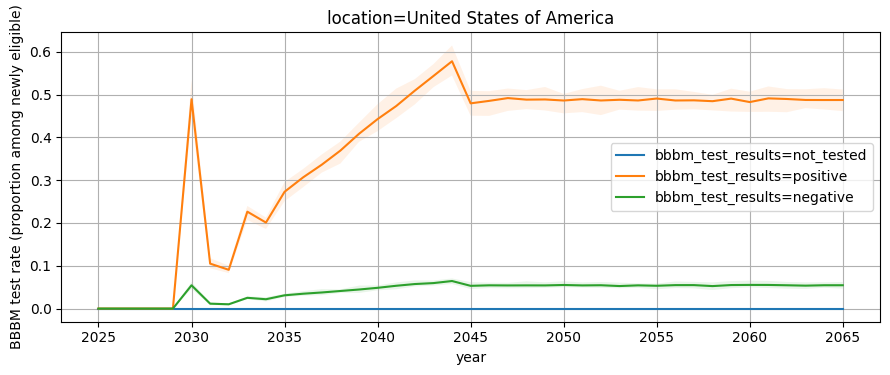

In [43]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate.query("scenario=='bbbm_testing'"),
    'bbbm_test_results',
    'location',
    ylabel='BBBM test rate (proportion among newly eligible)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
#     ax.set_xticks(ax.get_xticks()[::5])
plt.show()


# Check whether `not_tested` is ever nonzero among BBBM test counts

No, it's always zero. That's good.

In [44]:
# Good -- when counting tested simulants, the results are never "not tested"
bbbm_test_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([0.])

In [45]:
# On the other hand, among eligible simulants, there are lots of people
# who haven't been tested
bbbm_test_eligibility_counts.query("bbbm_test_results == 'not_tested'").value.unique()

array([   0., 1127.,  581., ..., 1186., 1227., 1360.])

# Check that among eligible similants, there are no positive tests

Yes, all counts of positive tests among eligible simulants are zero.

In [46]:
# Good -- among eligible simulants, no one has tested positive.
bbbm_test_eligibility_counts.query("bbbm_test_results == 'positive'").value.unique()

array([0.])

In [47]:
# On the other hand, among tested simulants, there are positive test results
len(bbbm_test_counts.query("bbbm_test_results == 'positive'").value.unique())

585

# Check test sensitivity

Filter to testing scenario and/or treatment scenario since there are no BBBM tests in baseline.

In [48]:
bbbm_test_sensitivity = ops.ratio(
    bbbm_test_counts,
    bbbm_test_counts,
    strata=['event_year'],
    # prefilter_query="scenario=='bbbm_testing'",
    # Broadcast in numerator to get positive and negative test results
    numerator_broadcast='bbbm_test_results',
    # dropna=True, # Drop rows with 0 testing (baseline scenario and years < 2030)
)
bbbm_test_sensitivity

,event_year,input_draw,scenario,location,bbbm_test_results,value,numerator_measure,denominator_measure,multiplier
0,2025,2,baseline,United States of America,not_tested,NaN,counts_bbbm_tests,counts_bbbm_tests,1
1,2025,2,baseline,United States of America,positive,NaN,counts_bbbm_tests,counts_bbbm_tests,1
2,2025,2,baseline,United States of America,negative,NaN,counts_bbbm_tests,counts_bbbm_tests,1
3,2025,2,bbbm_testing,United States of America,not_tested,NaN,counts_bbbm_tests,counts_bbbm_tests,1
4,2025,2,bbbm_testing,United States of America,positive,NaN,counts_bbbm_tests,counts_bbbm_tests,1
...,...,...,...,...,...,...,...,...,...
9220,2065,499,bbbm_testing,United States of America,positive,0.896515,counts_bbbm_tests,counts_bbbm_tests,1
9221,2065,499,bbbm_testing,United States of America,negative,0.103485,counts_bbbm_tests,counts_bbbm_tests,1
9222,2065,499,bbbm_testing_and_treatment,United States of America,not_tested,0.000000,counts_bbbm_tests,counts_bbbm_tests,1
9223,2065,499,bbbm_testing_and_treatment,United States of America,positive,0.896515,counts_bbbm_tests,counts_bbbm_tests,1


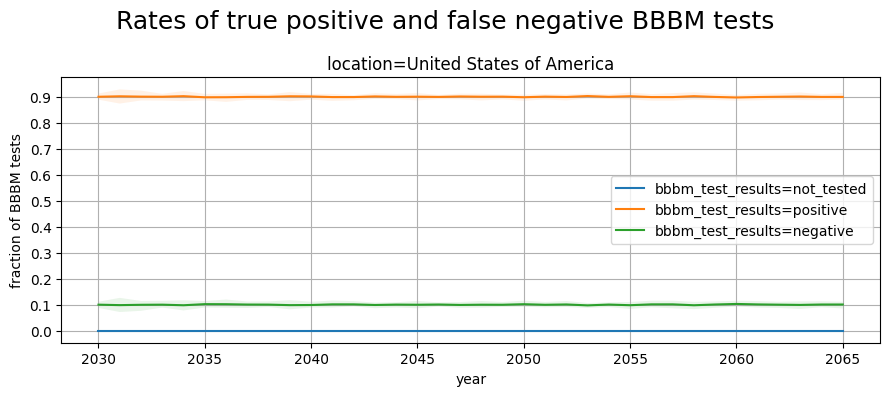

In [49]:
scenario = 'bbbm_testing_and_treatment'
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_sensitivity.query("scenario == 'bbbm_testing_and_treatment'"),
    'bbbm_test_results',
    'location',
    ylabel='fraction of BBBM tests',
    suptitle='Rates of true positive and false negative BBBM tests',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
    ax.grid(True)
plt.show()


# Compute statistics on BBBM test sensitivity

In [50]:
bbbm_test_sensitivity_summary = ops.describe(
    bbbm_test_sensitivity.dropna().query("event_year >= 2030 and bbbm_test_results=='positive'"))
bbbm_test_sensitivity_summary

count  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                            
positive          counts_bbbm_tests   2030       United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   
                                      2031       United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   
                                      2032       United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
...                                                                                                                                  ...   
                                      2063       United States of America 1          counts_bbbm_tests bbbm_testing_and_treatment   25.0   
                                      2064       United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   
                                      2065       United States of America 1          counts_bbbm_tests bbbm_testing                 25.0   
                                                                                                       bbbm_testing_and_treatment   25.0   

                                                                                                                                       mean  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                               
positive          counts_bbbm_tests   2030       United States of America 1          counts_bbbm_tests bbbm_testing                0.900011   
                                                                                                       bbbm_testing_and_treatment  0.900011   
                                      2031       United States of America 1          counts_bbbm_tests bbbm_testing                0.901748   
                                                                                                       bbbm_testing_and_treatment  0.901748   
                                      2032       United States of America 1          counts_bbbm_tests bbbm_testing                0.900469   
...                                                                                                                                     ...   
                                      2063       United States of America 1          counts_bbbm_tests bbbm_testing_and_treatment  0.900941   
                                      2064       United States of America 1          counts_bbbm_tests bbbm_testing                0.899390   
                                                                                                       bbbm_testing_and_treatment  0.899390   
                                      2065       United States of America 1          counts_bbbm_tests bbbm_testing                0.899403   
                                                                                                       bbbm_testing_and_treatment  0.899403   

                                                                                                                                        std  \
bbbm_test_results denominator_measure event_year location                 multiplier numerator_measure scenario                               
positive          counts_bbbm_tests   2030       United States of America 1          counts_bbbm_tests bbbm_testing                0.006963   
                     

In [51]:
bbbm_test_sensitivity_summary['mean'].describe()

count    72.000000
mean      0.899997
std       0.001312
min       0.897232
25%       0.899129
50%       0.899896
75%       0.900961
max       0.902693
Name: mean, dtype: float64

# Compute test result fractions among newly eligible simulants

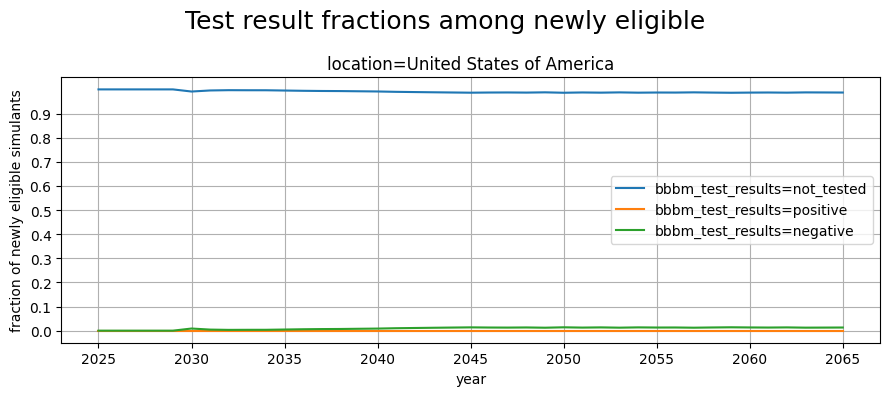

In [52]:
# TODO: Here would be a great place to use prefilter_query in the ratio
# function, once I implement it
bbbm_test_result_fractions_among_eligible = ops.ratio(
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    bbbm_test_eligibility_counts.query("scenario=='bbbm_testing'"),
    strata=['event_year'],
    numerator_broadcast='bbbm_test_results',
)

fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_result_fractions_among_eligible,
    'bbbm_test_results',
    'location',
    ylabel='fraction of newly eligible simulants',
    suptitle='Test result fractions among newly eligible',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.set_yticks(np.arange(0,1, .1))
plt.show()

# Plot numerators and denominators of BBBM test rate

In [53]:
bbbm_test_rate_numerator = ops.stratify(bbbm_test_counts, 'event_year')
bbbm_test_rate_denominator = ops.stratify(bbbm_test_eligibility_counts, 'event_year')
bbbm_test_rate_num_and_denom = pd.concat(
    [bbbm_test_rate_numerator, bbbm_test_rate_denominator],
    keys=['tests', 'newly_eligible'],
    names=['count'],
).reset_index('count').reset_index(drop=True)
bbbm_test_rate_num_and_denom

,count,event_year,input_draw,scenario,location,value
0,tests,2025,113,baseline,United States of America,0.0
1,tests,2025,113,bbbm_testing,United States of America,0.0
2,tests,2025,113,bbbm_testing_and_treatment,United States of America,0.0
3,tests,2025,346,baseline,United States of America,0.0
4,tests,2025,346,bbbm_testing,United States of America,0.0
...,...,...,...,...,...,...
6145,newly_eligible,2065,199,bbbm_testing,United States of America,3774.0
6146,newly_eligible,2065,199,bbbm_testing_and_treatment,United States of America,3774.0
6147,newly_eligible,2065,392,baseline,United States of America,4123.0
6148,newly_eligible,2065,392,bbbm_testing,United States of America,3707.0


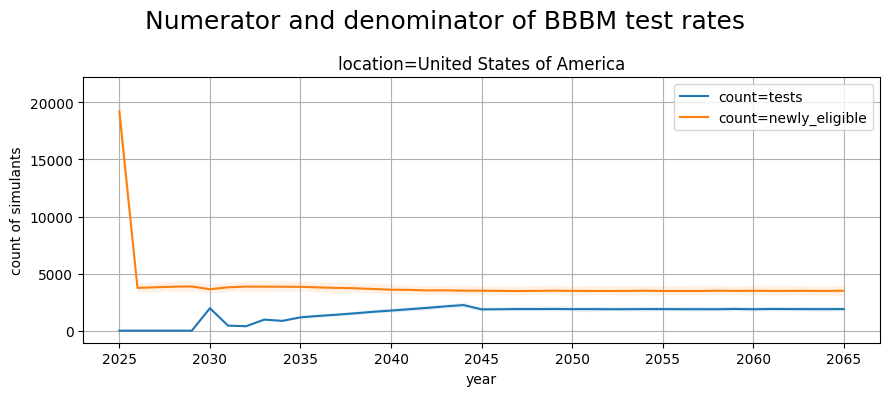

In [54]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_test_rate_num_and_denom.query("scenario=='bbbm_testing'"),
    'count',
    'location',
    ylabel='count of simulants',
    suptitle='Numerator and denominator of BBBM test rates',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.set_xticks(ax.get_xticks()[::5])
plt.show()

# Read in BBBM testing person-time data

In [55]:
pt_ever_eligible_bbbm = load_sim_output(
    'person_time_ever_eligible_for_bbbm_testing'
)
print_memory_usage(pt_ever_eligible_bbbm)
pt_ever_eligible_bbbm

16.610193 MB


,age_group,alzheimers_disease_and_other_dementias,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,baseline,Female,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,baseline,Male,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
830245,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,baseline,Male,0.000000,United States of America
830246,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,13.453799,United States of America
830247,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,4.484600,United States of America
830248,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,13.453799,United States of America


In [56]:
pt_eligible_bbbm = load_sim_output(
    'person_time_eligible_for_bbbm_testing'
)
print_memory_usage(pt_eligible_bbbm)
pt_eligible_bbbm

5.263055 MB


,age_group,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,not_tested,bbbm_testing,testing,2025,113,person_time_eligible_for_bbbm_testing,baseline,Female,0.0,United States of America
1,25_to_29,not_tested,bbbm_testing,testing,2025,113,person_time_eligible_for_bbbm_testing,baseline,Male,0.0,United States of America
2,25_to_29,not_tested,bbbm_testing,testing,2025,113,person_time_eligible_for_bbbm_testing,bbbm_testing,Female,0.0,United States of America
3,25_to_29,not_tested,bbbm_testing,testing,2025,113,person_time_eligible_for_bbbm_testing,bbbm_testing,Male,0.0,United States of America
4,25_to_29,not_tested,bbbm_testing,testing,2025,113,person_time_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...
276745,95_plus,negative,bbbm_testing,testing,2065,392,person_time_eligible_for_bbbm_testing,baseline,Male,0.0,United States of America
276746,95_plus,negative,bbbm_testing,testing,2065,392,person_time_eligible_for_bbbm_testing,bbbm_testing,Female,0.0,United States of America
276747,95_plus,negative,bbbm_testing,testing,2065,392,person_time_eligible_for_bbbm_testing,bbbm_testing,Male,0.0,United States of America
276748,95_plus,negative,bbbm_testing,testing,2065,392,person_time_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,0.0,United States of America


# Plot BBBM testing rate (counts / eligible person-time)

In [57]:
bbbm_tests_per_eligible_pt = ops.ratio(
    bbbm_test_counts,
    pt_eligible_bbbm,
    strata='event_year',
    # numerator_broadcast='bbbm_test_results',
)
bbbm_tests_per_eligible_pt

,event_year,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2025,113,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
1,2025,113,bbbm_testing,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
2,2025,113,bbbm_testing_and_treatment,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3,2025,346,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
4,2025,346,bbbm_testing,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...
3070,2065,199,bbbm_testing,United States of America,0.327502,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3071,2065,199,bbbm_testing_and_treatment,United States of America,0.327502,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3072,2065,392,baseline,United States of America,0.000000,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1
3073,2065,392,bbbm_testing,United States of America,0.308663,counts_bbbm_tests,person_time_eligible_for_bbbm_testing,1


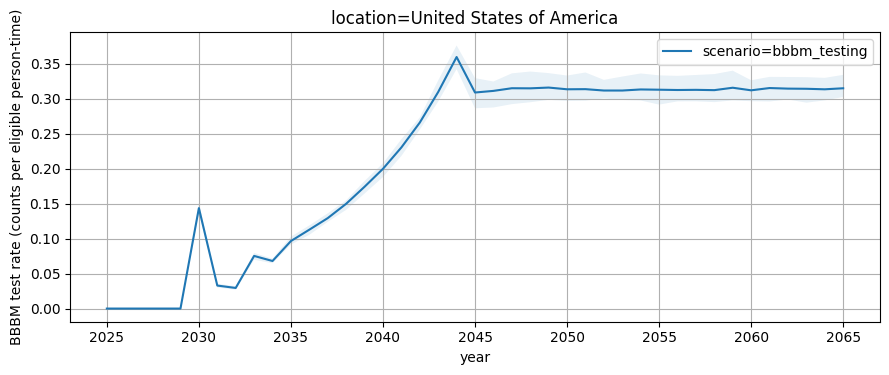

In [58]:
fig = plot_over_time_by_column_for_row_x_1(
    bbbm_tests_per_eligible_pt.query("scenario=='bbbm_testing'"),
    # 'bbbm_test_results',
    'scenario',
    'location',
    ylabel='BBBM test rate (counts per eligible person-time)',
    uncertainty=True,
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


# Compute prevalence of ever tested among ever eligible

In [59]:
pt_ever_eligible_bbbm.bbbm_test_results.unique()

['not_tested', 'positive', 'negative']
Categories (3, object): ['negative', 'not_tested', 'positive']

In [60]:
pt_ever_eligible_bbbm

,age_group,alzheimers_disease_and_other_dementias,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,baseline,Female,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,baseline,Male,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
830245,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,baseline,Male,0.000000,United States of America
830246,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,13.453799,United States of America
830247,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,4.484600,United States of America
830248,95_plus,alzheimers_disease_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing_and_treatment,Female,13.453799,United States of America


In [61]:
ever_tested_over_ever_eligible = ops.ratio(
    pt_ever_eligible_bbbm.query(
        "bbbm_test_results != 'not_tested'"),
    pt_ever_eligible_bbbm,
    strata=['event_year', 'age_group'],
    prefilter_query="alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'",
)#.query("scenario == 'bbbm_testing_and_treatment'")
ever_tested_over_ever_eligible

,event_year,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,2025,25_to_29,113,baseline,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
1,2025,25_to_29,113,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
2,2025,25_to_29,113,bbbm_testing_and_treatment,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
3,2025,25_to_29,346,baseline,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
4,2025,25_to_29,346,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
46120,2065,95_plus,199,bbbm_testing,United States of America,0.454545,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
46121,2065,95_plus,199,bbbm_testing_and_treatment,United States of America,0.520000,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
46122,2065,95_plus,392,baseline,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
46123,2065,95_plus,392,bbbm_testing,United States of America,0.679245,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1


In [62]:
ever_tested_over_ever_eligible['age_group']

0        25_to_29
1        25_to_29
2        25_to_29
3        25_to_29
4        25_to_29
           ...   
46120     95_plus
46121     95_plus
46122     95_plus
46123     95_plus
46124     95_plus
Name: age_group, Length: 46125, dtype: category
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

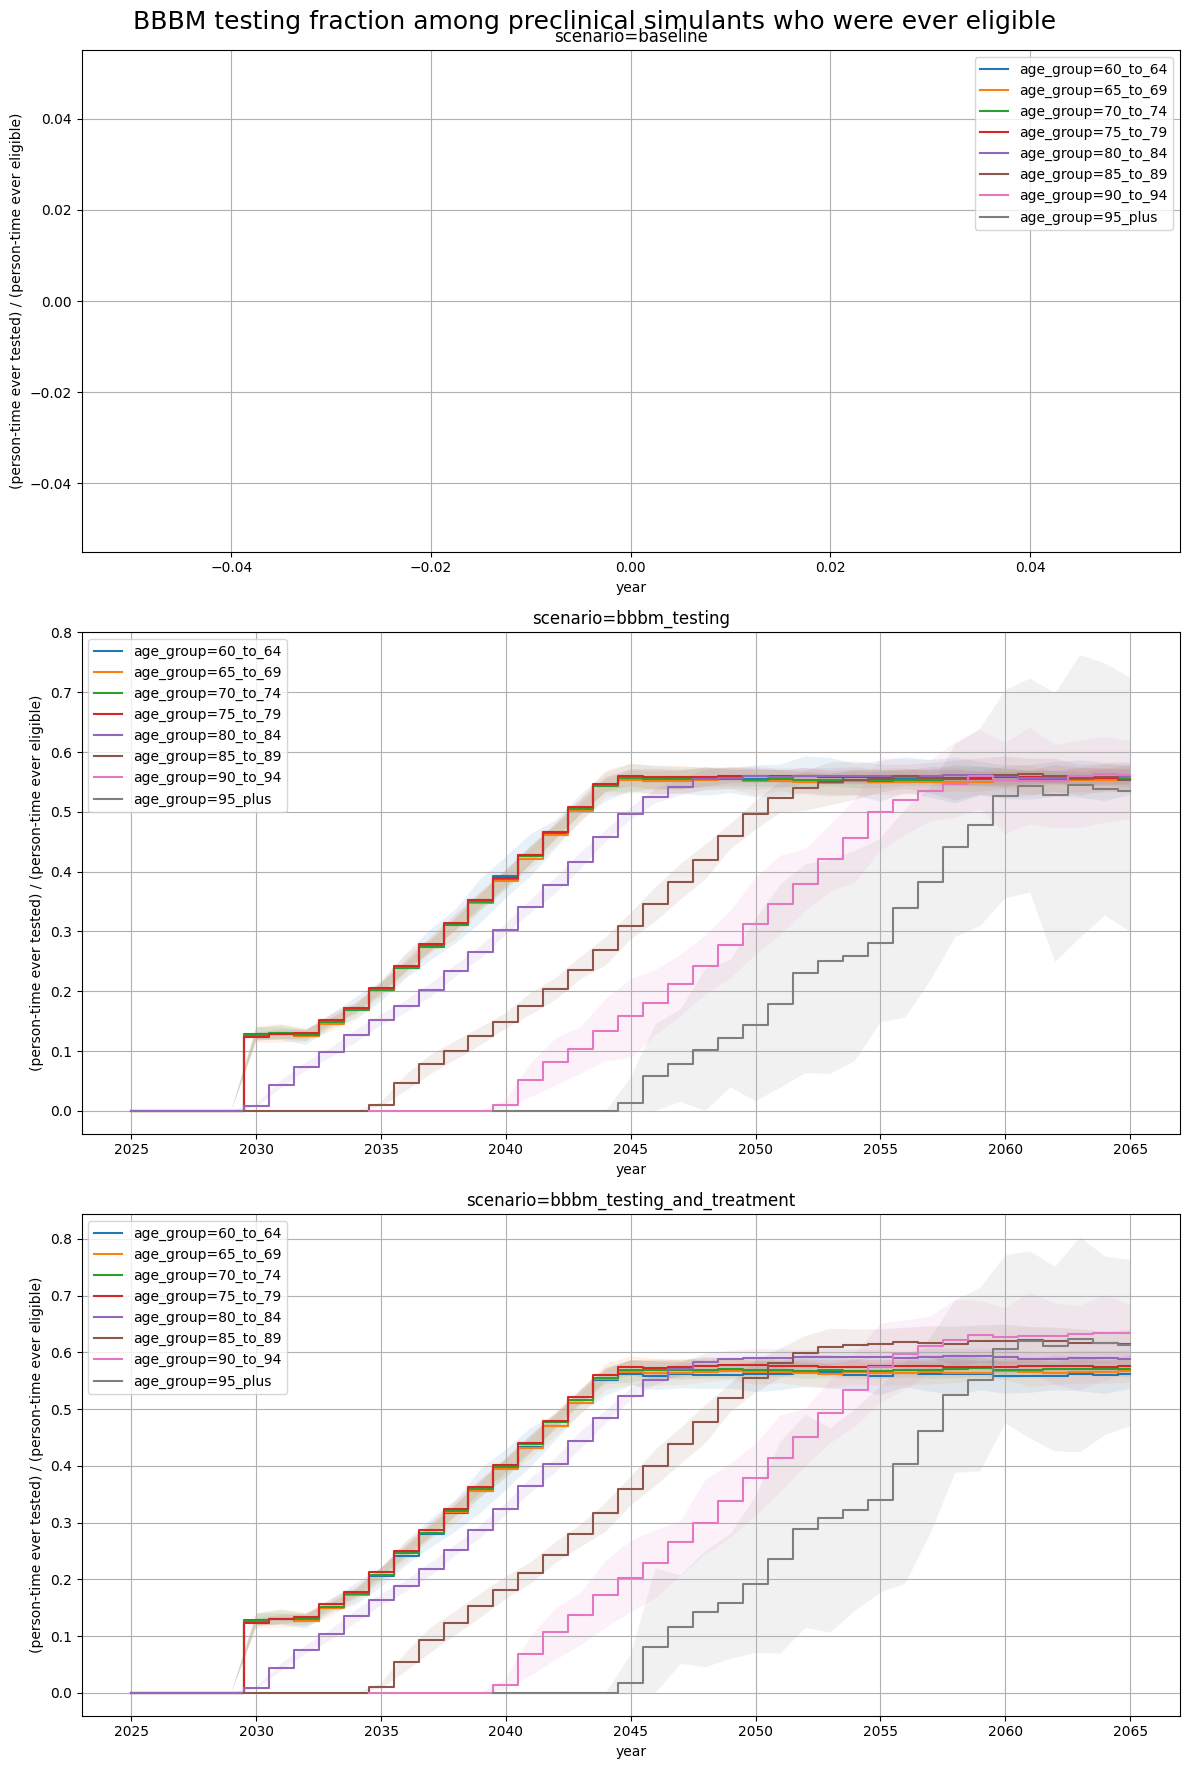

In [63]:
# NOTE: I got "ValueError: unknown type object" when calling 
# .query("age_group < '60_to_64'") -- I fixed this by converting the
# dtype from Categorical to string. Using .loc doesn't work either
# because you can't compare unordered Categoricals. If we used an
# ordered Categorical for the age groups, that might make this easier.
# fig, ax = plt.subplots(figsize=(12, 6))
fig = plot_over_time_by_column_for_row_x_1(
    ever_tested_over_ever_eligible.astype({'age_group': str})
        .query("age_group >= '60_to_64'"),
        #.loc[ever_tested_over_ever_eligible.age_group < '60_to_64'],
        # .query("age_group in ['60_to_64', '65_to_69', '70_to_74', '75_to_79']"),
    'age_group',
    'scenario',
    # ax=ax,
    ylabel='(person-time ever tested) / (person-time ever eligible)',
    suptitle='BBBM testing fraction among preclinical simulants who were ever eligible',
    # plot_func='step',
    # where='post',
    ds='steps-mid',
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::5])
    ax.grid(True)
plt.show()


## Questions:

* Why exactly is the fraction of people tested constant for the first 3
  years?

* Why exactly do all the age groups level off at the same value between
  55% and 60%?

## Check if the ratio is still 1.0 for any age groups

No, not any more. That's good.

In [64]:
temp = ever_tested_over_ever_eligible.query("value==1.0 and scenario=='bbbm_testing'")
print(temp.age_group.unique())
temp

[], Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']


,event_year,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier


In [65]:
temp = pt_ever_eligible_bbbm.query(
    "scenario=='bbbm_testing' and age_group=='80_to_84'"
    " and alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"
)
temp

,age_group,alzheimers_disease_and_other_dementias,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
608852,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,197.820671,United States of America
608853,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,89.691992,United States of America
608858,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,346,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,270.072553,United States of America
608859,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,346,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,131.049966,United States of America
608864,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,273,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,232.202601,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
627285,80_to_84,alzheimers_blood_based_biomarker_state,negative,bbbm_testing,testing,2065,24,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,63.282683,United States of America
627290,80_to_84,alzheimers_blood_based_biomarker_state,negative,bbbm_testing,testing,2065,199,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,78.231348,United States of America
627291,80_to_84,alzheimers_blood_based_biomarker_state,negative,bbbm_testing,testing,2065,199,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,50.825462,United States of America
627296,80_to_84,alzheimers_blood_based_biomarker_state,negative,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,81.221081,United States of America


In [66]:
temp.query("bbbm_test_results=='not_tested'")

,age_group,alzheimers_disease_and_other_dementias,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
608852,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,197.820671,United States of America
608853,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,113,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,89.691992,United States of America
608858,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,346,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,270.072553,United States of America
608859,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,346,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,131.049966,United States of America
608864,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2025,273,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,232.202601,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
614985,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2065,24,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,707.570157,United States of America
614990,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2065,199,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,1171.975359,United States of America
614991,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2065,199,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Male,614.888433,United States of America
614996,80_to_84,alzheimers_blood_based_biomarker_state,not_tested,bbbm_testing,testing,2065,392,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,Female,1108.194387,United States of America
